https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/#comment-417989

In [1]:
%load_ext autoreload
%autoreload 2

# First step, import libraries.
import numpy as np 
import pandas as pd 
import seaborn as sb
from matplotlib import pyplot as plt
from utils import split_data, difference
%matplotlib inline

In [2]:
DATA_PATH = "../data/bitcoin-historical-data/coinbaseUSD_1-min_data_2014-12-01_to_2017-10-20.csv.csv"
PRED_DAYS = 30  # num prediction days for the trained models

In [3]:
# Import the dataset and encode the date
df = pd.read_csv(DATA_PATH)
df['Date'] = pd.to_datetime(df['Timestamp'],unit='s').dt.date  # convert date human readable 
group = df.groupby('Date')

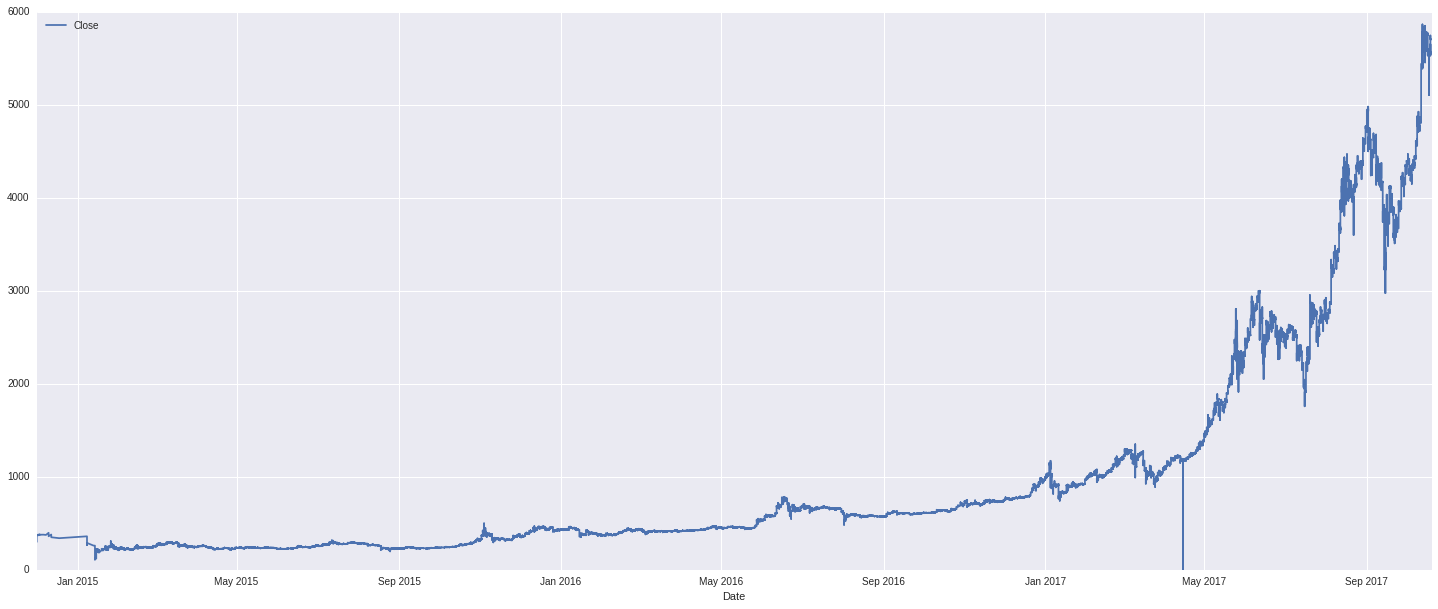

In [4]:
# plot the history
df.plot(x='Date', y='Close', figsize=[25, 10])

In [5]:
day_close_price = group['Weighted_Price'].last()  # not true but approximation to start
print(" # of days we have: {}".format(len(day_close_price)))

 # of days we have: 1021


In [6]:
# split data
df_train, df_test = split_data(day_close_price, 30)

 Train data size 991
 Test data size 30


In [40]:
from sklearn.preprocessing import MinMaxScaler

# Data preprocess
X_train = difference(df_train.values)  # trend removal
X_train = X_train[:, None]

# MaxMin scale input for NN
sc = MinMaxScaler() 
X_train = sc.fit_transform(X_train)

# set train set and labels
y_train = X_train[1:len(X_train)]
X_train = X_train[0:len(X_train)-1]
X_train = np.reshape(X_train, (len(X_train), 1, 1))

In [41]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tqdm import tqdm

# Initialising the RNN
regressor = Sequential()

# Adding the input layer and the LSTM layer
regressor.add(LSTM(units = 4, activation = 'sigmoid', input_shape = (None, 1), stateful=True, batch_input_shape=[1,1,1]))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
for i in range(1000):
    print(" ---- "+str(i))
    regressor.fit(X_train, y_train, epochs=1, batch_size=1, verbose=True, shuffle=False)
    regressor.reset_states()

 ---- 0
Epoch 1/1
989/989 [==============================] - 6s - loss: 0.0045     
 ---- 1
Epoch 1/1
989/989 [==============================] - 7s - loss: 0.0026     
 ---- 2
Epoch 1/1
989/989 [==============================] - 6s - loss: 0.0026     
 ---- 3
Epoch 1/1
989/989 [==============================] - 6s - loss: 0.0026     
 ---- 4
Epoch 1/1
989/989 [==============================] - ETA: 0s - loss: 0.002 - 6s - loss: 0.0026     
 ---- 5
Epoch 1/1
989/989 [==============================] - 6s - loss: 0.0026     
 ---- 6
Epoch 1/1
989/989 [==============================] - 6s - loss: 0.0026     
 ---- 7
Epoch 1/1
989/989 [==============================] - 6s - loss: 0.0026     
 ---- 8
Epoch 1/1
989/989 [==============================] - 6s - loss: 0.0026     
 ---- 9
Epoch 1/1
989/989 [==============================] - 6s - loss: 0.0026     
 ---- 10
Epoch 1/1
989/989 [==============================] - 6s - loss: 0.0026     
 ---- 11
Epoch 1/1
989/989 [=======================

KeyboardInterrupt: 

In [42]:
# Making the predictions
X_test = difference(df_test.values)  # trend removal
X_test = X_test[:, None]
X_test = sc.transform(X_test)
X_test = np.reshape(X_test, (len(X_test), 1, 1))

In [80]:
len(df_test.values)


30

In [109]:
# walk-forward validation on the test data
price_preds = list()
price_labels = list()
change_preds = list()
change_labels = list()

for i in range(0,len(X_test)-1):
    # expected value for the round
    price_label = df_test.values[i+2]
    change_label = sc.inverse_transform(X_test[i+1])
    # make one-step forecast
    X = X_test[i]
    yhat = regressor.predict(X.reshape(1, 1, len(X)), batch_size=1)
    # invert scaling
    change_pred = sc.inverse_transform(yhat)
    # invert differencing
    price_pred = df_test.values[i+1] + change_pred
    # store change forecast
    change_preds.append(change_pred.flatten())
    change_labels.append(change_label.flatten())
    # store price forecast
    price_preds.append(price_pred[0][0])
    price_labels.append(price_label)
    print('Month=%d, Predicted=%f, Expected=%f, Predicted_change=%f, Expected_change=%f' % (i+1, price_pred, price_label, change_pred, change_label))

Month=1, Predicted=3620.265869, Expected=3785.833078, Predicted_change=1.255794, Expected_change=166.823078
Month=2, Predicted=3779.533203, Expected=3669.558068, Predicted_change=-6.299690, Expected_change=-116.275011
Month=3, Predicted=3675.568115, Expected=3920.013694, Predicted_change=6.010022, Expected_change=250.455626
Month=4, Predicted=3909.870850, Expected=3885.083003, Predicted_change=-10.142860, Expected_change=-34.930690
Month=5, Predicted=3887.575928, Expected=4200.000000, Predicted_change=2.492849, Expected_change=314.916997
Month=6, Predicted=4186.678223, Expected=4189.417849, Predicted_change=-13.321695, Expected_change=-10.582151
Month=7, Predicted=4190.338379, Expected=4156.931699, Predicted_change=0.920542, Expected_change=-32.486150
Month=8, Predicted=4158.406738, Expected=4339.008579, Predicted_change=1.474967, Expected_change=182.076880
Month=9, Predicted=4331.738281, Expected=4394.809390, Predicted_change=-7.270437, Expected_change=55.800810
Month=10, Predicted=43

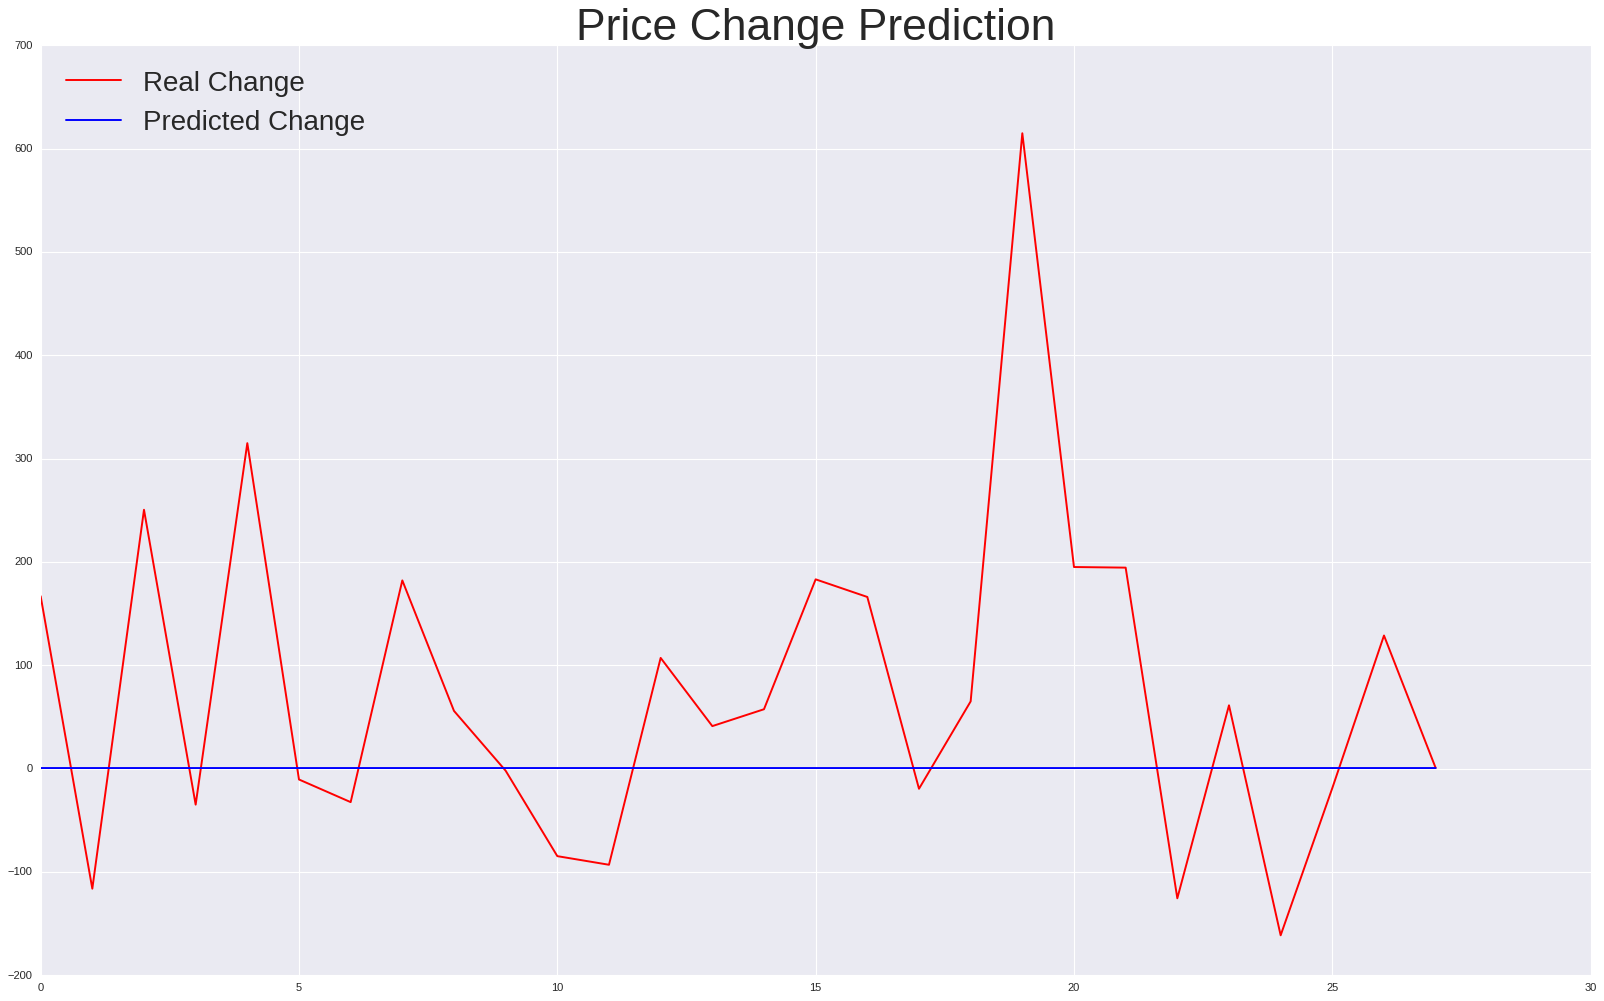

In [111]:
# Visualising the results
plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  

plt.plot(change_labels, color = 'red', label = 'Real Change')
plt.plot(change_predictions, color = 'blue', label = 'Predicted Change')

plt.title('Price Change Prediction', fontsize=40)
plt.legend(loc=2, prop={'size': 25})
plt.show()

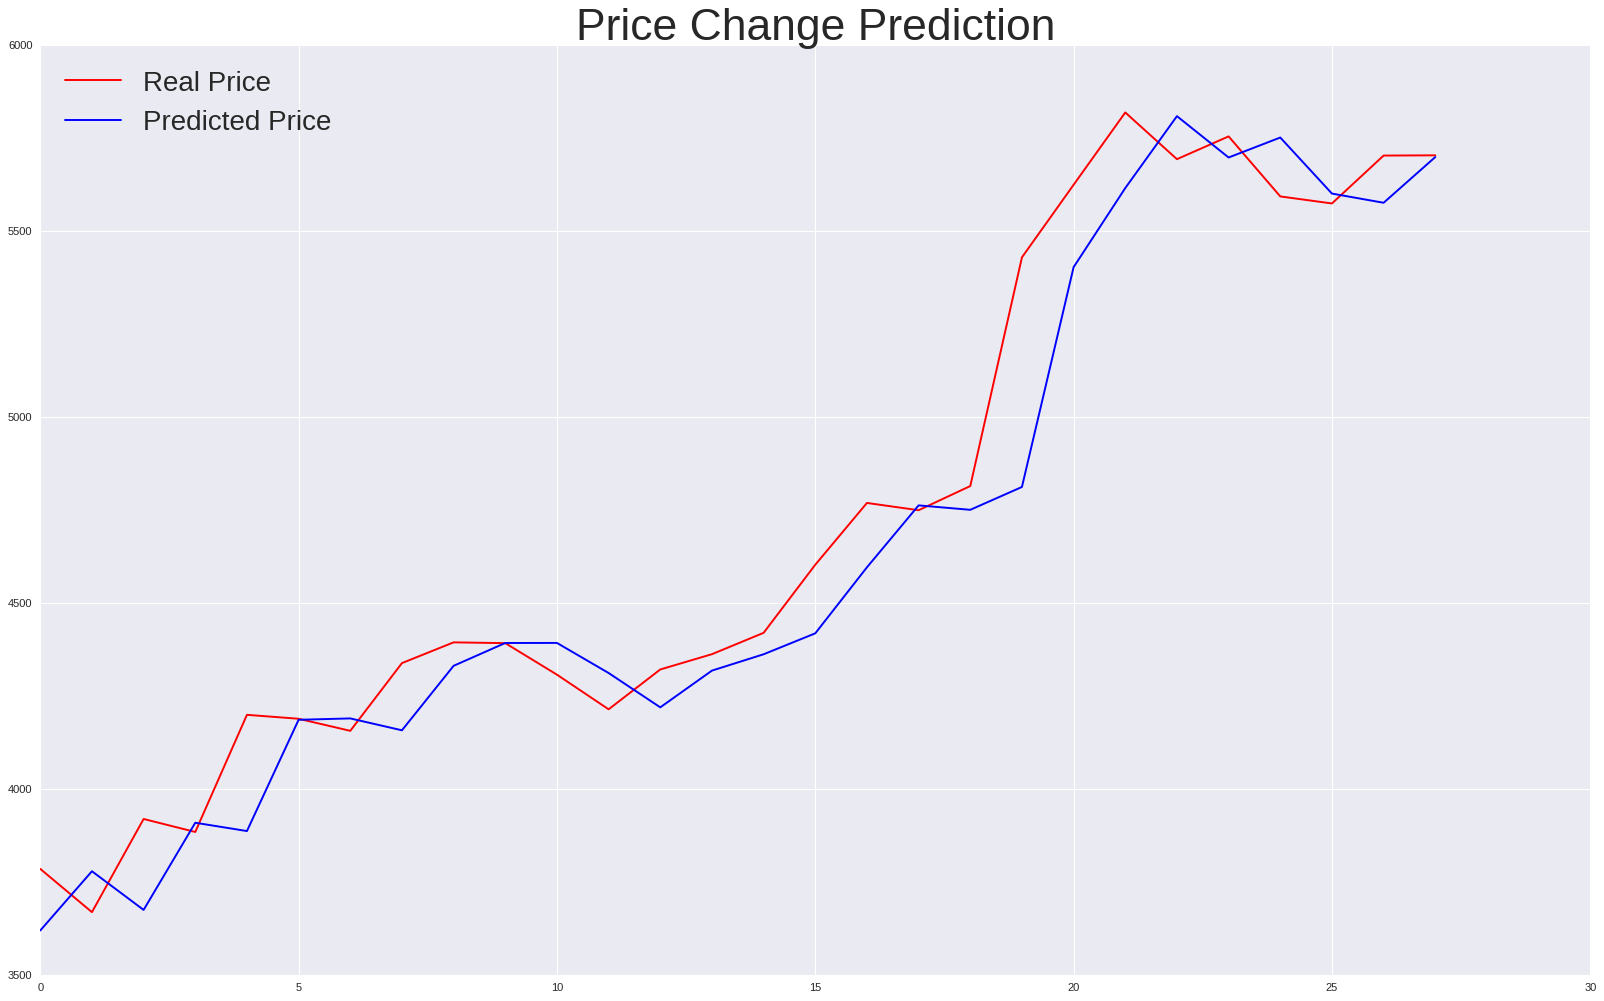

In [110]:
# Visualising the results
plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  

plt.plot(price_labels, color = 'red', label = 'Real Price')
plt.plot(price_preds, color = 'blue', label = 'Predicted Price')

plt.title('Price Change Prediction', fontsize=40)
plt.legend(loc=2, prop={'size': 25})
plt.show()

Gist:
    - Do not plot predicted price vs real price, it is damn misleading.
    - LSTM does not suit well to the problem. As the plot above shows. 